In [90]:
pip install pycaret

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install haversine

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [93]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [94]:
target = train['emission']

In [95]:
train = train[["latitude", "longitude", "year", "week_no"]]
test = test[["latitude", "longitude", "year", "week_no"]]

In [96]:
train.isnull().sum().sort_values(ascending = False)

latitude     0
longitude    0
year         0
week_no      0
dtype: int64

In [97]:
test.isnull().sum().sort_values(ascending = False)

latitude     0
longitude    0
year         0
week_no      0
dtype: int64

In [98]:
#Feature Engineering
train['month'] = train['week_no'] // 4.3445
train['covid_start'] = ((train['year'] == 2020) & (train['month'].isin([3, 4]))).astype(int)
train['lockdown_period'] = ((train['year'] == 2020) & (train['month'].isin([3, 4]))).astype(int)
train['Covid_period'] = (((train['year'] == 2020) & (train['month'] >= 3)) | ((train['year'] == 2021) & (train['month'] <= 8))).astype(int).astype(int)

#max_emission = train['emission'].max()
#train['distance_to_max_emission'] = abs(train['emission'] - max_emission)

# List of public holidays
holidays_2019 = ["January 01 2019", "February 01 2019", "April 07 2019", "April 19 2019", "May 01 2019",
                 "June 05 2019", "July 01 2019", "July 04 2019", "August 15 2019", "December 25 2019",
                 "December 26 2019"]

holidays_2020 = ["January 01 2020", "January 02 2020", "February 01 2020", "February 03 2020", "April 07 2020",
                 "April 10 2020", "April 13 2020", "May 01 2020", "May 24 2020", "July 01 2020",
                 "July 04 2020", "July 06 2020", "July 31 2020", "August 07 2020", "August 15 2020",
                 "August 17 2020", "December 25 2020", "December 26 2020", "December 28 2020"]

holidays_2021 = ["January 01 2021", "January 04 2021", "February 01 2021", "April 02 2021", "April 05 2021",
                 "April 07 2021", "May 01 2021", "May 03 2021", "May 13 2021", "July 01 2021",
                 "July 04 2021", "July 05 2021", "July 20 2021", "August 06 2021", "August 15 2021",
                 "December 25 2021", "December 26 2021", "December 27 2021"]

# Concatenate all holidays
all_holidays = holidays_2019 + holidays_2020 + holidays_2021

# Create the 'public_holidays' column
train['public_holidays'] = train['year'].astype(str) + '-' + train['month'].astype(str)
train['public_holidays'] = train['public_holidays'].isin(all_holidays).astype(int)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit KMeans model to emission values
#train['emission_cluster'] = kmeans.fit_predict(train[['emission']].values)

coords = train[['latitude', 'longitude']]

# Create a KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit KMeans model to coordinates
train['location_cluster'] = kmeans.fit_predict(coords)
train.head()

,latitude,longitude,year,week_no,month,covid_start,lockdown_period,Covid_period,public_holidays,location_cluster
0,-0.51,29.29,2019,0,0.0,0,0,0,0,0
1,-0.51,29.29,2019,1,0.0,0,0,0,0,0
2,-0.51,29.29,2019,2,0.0,0,0,0,0,0
3,-0.51,29.29,2019,3,0.0,0,0,0,0,0
4,-0.51,29.29,2019,4,0.0,0,0,0,0,0


In [99]:
#Feature Engineering
test['month'] = test['week_no'] // 4.3445
test['covid_start'] = ((test['year'] == 2020) & (test['month'].isin([3, 4]))).astype(int)
test['lockdown_period'] = ((test['year'] == 2020) & (test['month'].isin([3, 4]))).astype(int)
test['Covid_period'] = (((test['year'] == 2020) & (test['month'] >= 2)) | ((test['year'] == 2021) & (test['month'] <= 7))).astype(int).astype(int)

# Create the 'public_holidays' column
test['public_holidays'] = test['year'].astype(str) + '-' + test['month'].astype(str)
test['public_holidays'] = test['public_holidays'].isin(all_holidays).astype(int)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)

coords = test[['latitude', 'longitude']]

# Create a KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit KMeans model to coordinates
test['location_cluster'] = kmeans.fit_predict(coords)
test.head()



,latitude,longitude,year,week_no,month,covid_start,lockdown_period,Covid_period,public_holidays,location_cluster
0,-0.51,29.29,2022,0,0.0,0,0,0,0,2
1,-0.51,29.29,2022,1,0.0,0,0,0,0,2
2,-0.51,29.29,2022,2,0.0,0,0,0,0,2
3,-0.51,29.29,2022,3,0.0,0,0,0,0,2
4,-0.51,29.29,2022,4,0.0,0,0,0,0,2


In [100]:
# Location Interaction Feature
train['location_interaction'] = train['latitude'] * train['longitude']
test['location_interaction'] = test['latitude'] * test['longitude']

# Quarter Feature
train['quarter'] = (train['week_no'] - 1) // 13 + 1
test['quarter'] = (test['week_no'] - 1) // 13 + 1


In [123]:
from sklearn.decomposition import PCA
train['rot_15_x'] = (np.cos(np.radians(15)) * train['longitude']) + (np.sin(np.radians(15)) * train['latitude'])
train['rot_15_y'] = (np.cos(np.radians(15)) * train['latitude']) + (np.sin(np.radians(15)) * train['longitude'])
train['rot_30_x'] = (np.cos(np.radians(30)) * train['longitude']) + (np.sin(np.radians(30)) * train['latitude'])
train['rot_30_y'] = (np.cos(np.radians(30)) * train['latitude']) + (np.sin(np.radians(30)) * train['longitude'])

test['rot_15_x'] = (np.cos(np.radians(15)) * test['longitude']) + (np.sin(np.radians(15)) * test['latitude'])
test['rot_15_y'] = (np.cos(np.radians(15)) * test['latitude']) + (np.sin(np.radians(15)) * test['longitude'])
test['rot_30_x'] = (np.cos(np.radians(30)) * test['longitude']) + (np.sin(np.radians(30)) * test['latitude'])
test['rot_30_y'] = (np.cos(np.radians(30)) * test['latitude']) + (np.sin(np.radians(30)) * test['longitude'])

train['week_sin'] = np.sin(2 * np.pi * train['week_no']/53)
train['week_cos'] = np.cos(2 * np.pi * train['week_no']/53)

test['week_sin'] = np.sin(2 * np.pi * test['week_no']/53)
test['week_cos'] = np.cos(2 * np.pi * test['week_no']/53)

train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)

test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)

coordinates = train[['latitude','longitude']].values
pca_obj = PCA().fit(coordinates)

train['pca_x'] = pca_obj.transform(train[['latitude', 'longitude']])[:,0]
train['pca_y'] = pca_obj.transform(train[['latitude', 'longitude']])[:,1]

test['pca_x'] = pca_obj.transform(test[['latitude', 'longitude']])[:,0]
test['pca_y'] = pca_obj.transform(test[['latitude', 'longitude']])[:,1]

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              79023 non-null  float64
 1   longitude             79023 non-null  float64
 2   year                  79023 non-null  int64  
 3   week_no               79023 non-null  int64  
 4   month                 79023 non-null  float64
 5   covid_start           79023 non-null  int32  
 6   lockdown_period       79023 non-null  int32  
 7   Covid_period          79023 non-null  int32  
 8   public_holidays       79023 non-null  int32  
 9   location_cluster      79023 non-null  int32  
 10  location_interaction  79023 non-null  float64
 11  quarter               79023 non-null  int64  
 12  rot_15_x              79023 non-null  float64
 13  rot_15_y              79023 non-null  float64
 14  rot_30_x              79023 non-null  float64
 15  rot_30_y           

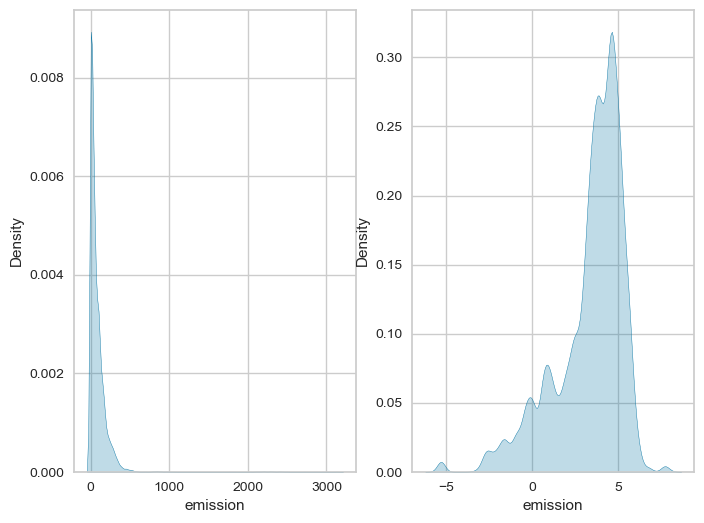

In [125]:
#dist plot to get the skewness of the target
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.kdeplot(target, shade=True)

plt.subplot(1,2,2)
sns.kdeplot(np.log(target), shade=True)
plt.show()

In [126]:
from pycaret.regression import *

In [127]:
var = setup(data=pd.concat([train,target],axis=1), target='emission')

,Description,Value
0,Session id,1884
1,Target,emission
2,Target type,Regression
3,Original data shape,"(79023, 23)"
4,Transformed data shape,"(79023, 23)"
5,Transformed train set shape,"(55316, 23)"
6,Transformed test set shape,"(23707, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


In [128]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.5172,209.4485,13.8463,0.9897,0.0892,0.0481,8.0890
rf,Random Forest Regressor,3.7269,216.9229,14.2098,0.9893,0.0916,0.0531,11.8910
xgboost,Extreme Gradient Boosting,7.6339,273.4344,16.1811,0.9865,0.5594,5.1695,2.9970
dt,Decision Tree Regressor,4.3419,305.6297,17.1333,0.9849,0.1131,0.0541,1.1230
lightgbm,Light Gradient Boosting Machine,14.9280,603.8018,24.4483,0.9697,0.8738,15.1190,3.2500
gbr,Gradient Boosting Regressor,37.9219,4388.4741,65.8282,0.7825,1.3101,38.9294,4.1510
ada,AdaBoost Regressor,62.5206,7087.7065,84.1575,0.6449,1.7744,81.3213,1.5820
knn,K Neighbors Regressor,51.2854,14279.9543,119.1992,0.2935,1.3823,38.8092,7.3320
lr,Linear Regression,70.7611,19739.7557,140.2571,0.0232,1.8655,82.2326,1.7660
br,Bayesian Ridge,70.4301,19859.5347,140.6804,0.0174,1.8762,87.5968,0.9450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=1884)

In [129]:
train.shape

(79023, 22)

In [130]:
test.shape

(24353, 22)

In [131]:
train.describe()

,latitude,longitude,year,week_no,month,covid_start,lockdown_period,Covid_period,public_holidays,location_cluster,...,rot_15_x,rot_15_y,rot_30_x,rot_30_y,week_sin,week_cos,month_sin,month_cos,pca_x,pca_y
count,79023.000000,79023.000000,79023.000000,79023.000000,79023.000000,79023.000000,79023.000000,79023.000000,79023.0,79023.000000,...,79023.000000,79023.000000,79023.000000,79023.000000,7.902300e+04,7.902300e+04,7.902300e+04,7.902300e+04,7.902300e+04,7.902300e+04
mean,-1.891072,29.880155,2020.000000,26.000000,5.471698,0.050314,0.050314,0.496855,0.0,1.444668,...,28.372568,5.906917,24.931437,13.302361,9.658939e-21,-6.703093e-17,-6.703795e-17,1.886792e-02,-3.137589e-14,1.181837e-14
std,0.694522,0.810375,0.816502,15.297155,3.505295,0.218594,0.218594,0.499993,0.0,1.090231,...,0.844056,0.749294,0.854321,0.801680,7.071113e-01,7.071113e-01,7.004086e-01,7.135015e-01,8.544401e-01,6.395323e-01
min,-3.299000,28.228000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,26.496944,4.410791,22.960165,11.540172,-9.995608e-01,-9.982437e-01,-1.000000e+00,-1.000000e+00,-1.936202e+00,-1.468973e+00
25%,-2.451000,29.262000,2019.000000,13.000000,2.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,27.703082,5.239205,24.276471,12.634884,-6.965510e-01,-7.175073e-01,-5.000000e-01,-5.000000e-01,-6.291426e-01,-4.819712e-01
50%,-1.882000,29.883000,2020.000000,26.000000,5.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,28.369343,5.928323,24.910500,13.365234,0.000000e+00,2.963333e-02,0.000000e+00,6.123234e-17,1.551080e-02,-2.789497e-02
75%,-1.303000,30.471000,2021.000000,39.000000,8.000000,0.000000,0.000000,1.000000,0.0,2.000000,...,28.983176,6.525690,25.570377,13.982889,6.965510e-01,6.749830e-01,5.000000e-01,8.660254e-01,6.627232e-01,5.001527e-01
max,-0.510000,31.532000,2021.000000,52.000000,11.000000,1.000000,1.000000,1.000000,0.0,3.000000,...,30.212260,7.399582,26.871604,15.048984,9.995608e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.967871e+00,1.507741e+00


In [132]:
y_train = target
X_train = train

In [133]:
X_train.shape

(79023, 22)

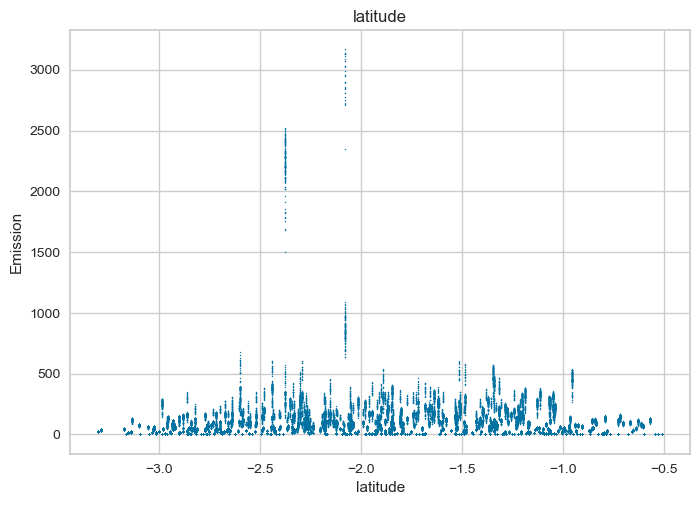

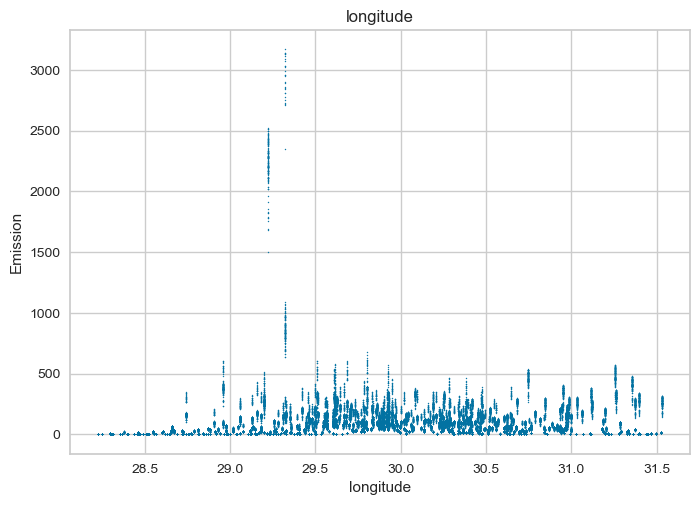

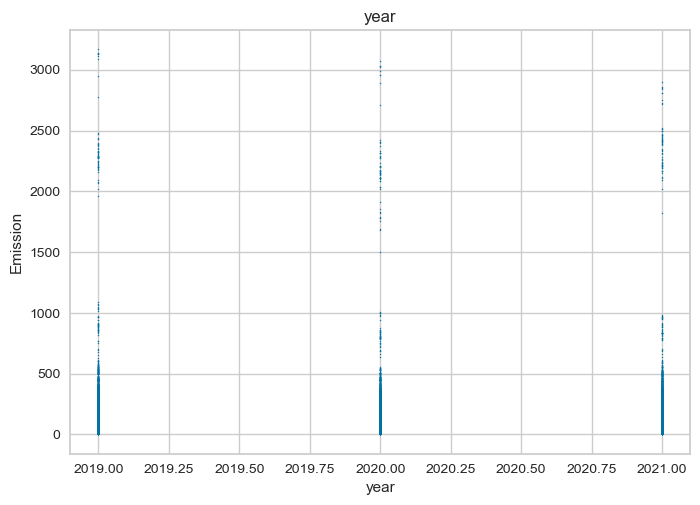

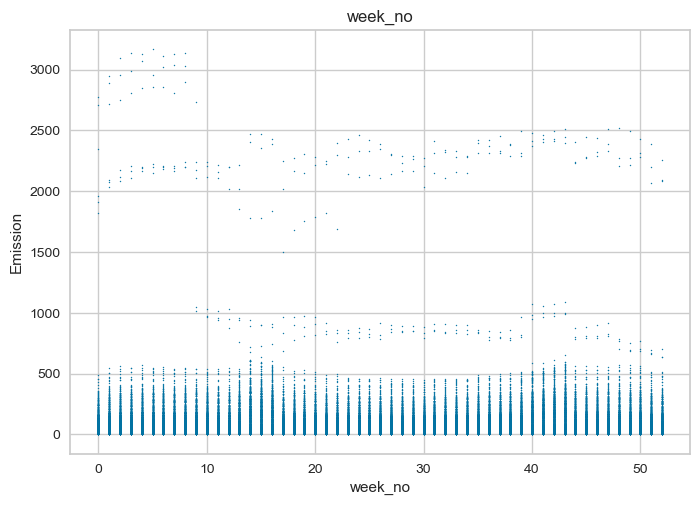

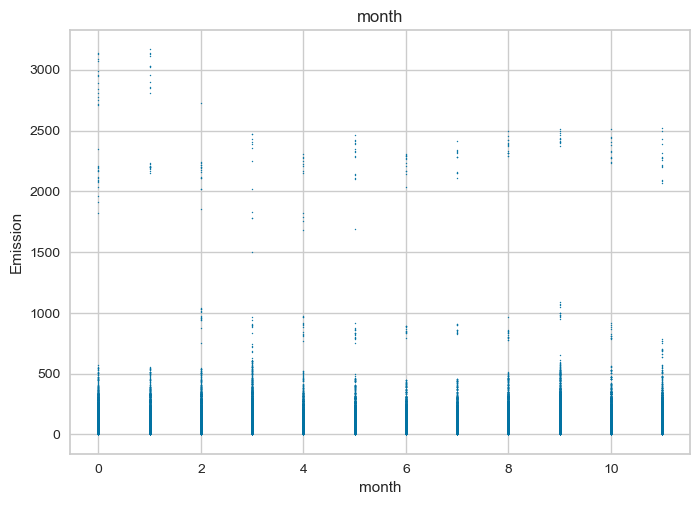

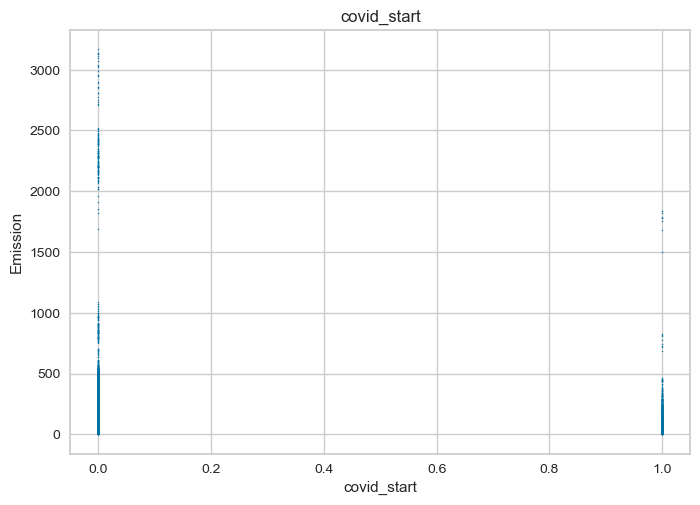

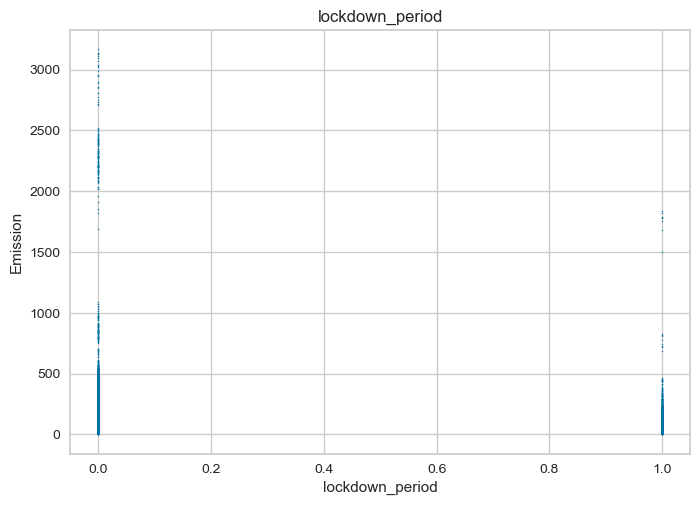

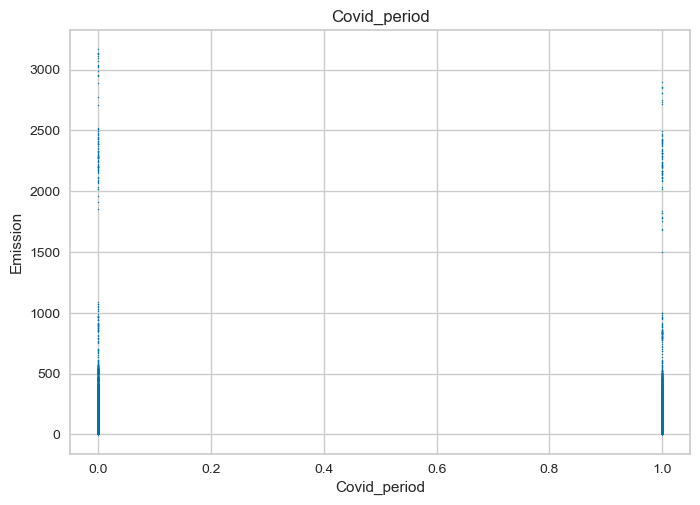

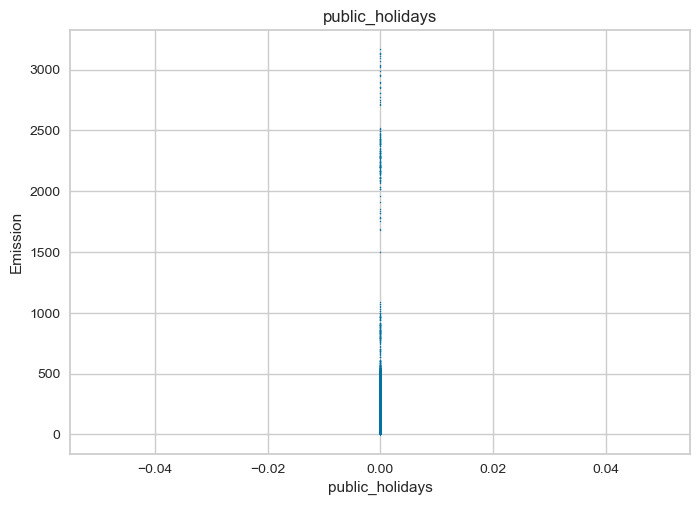

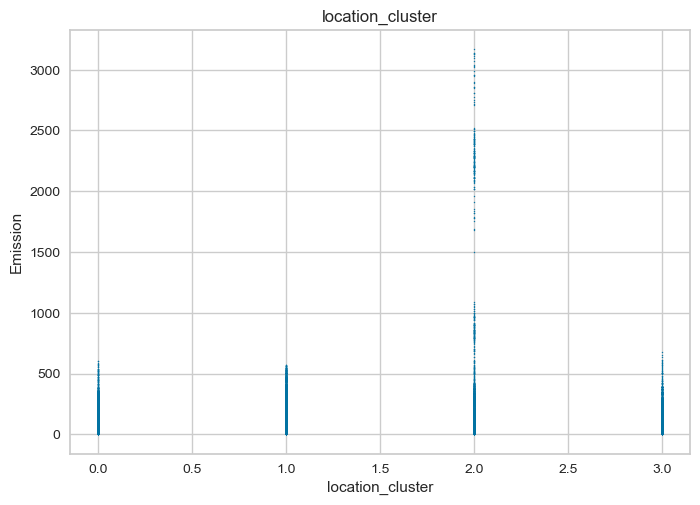

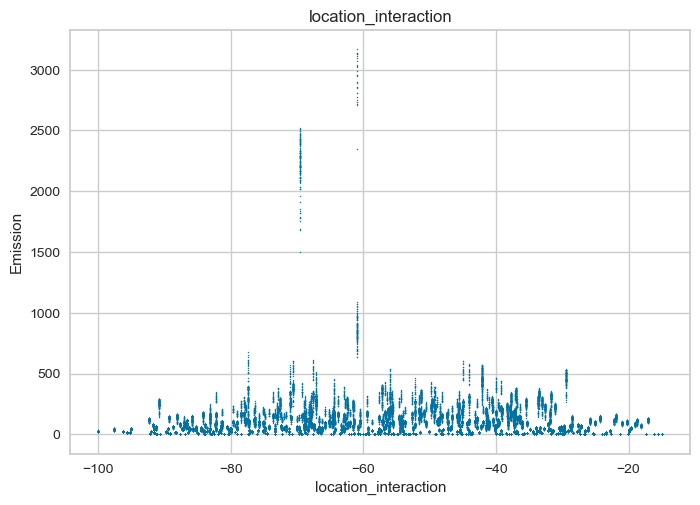

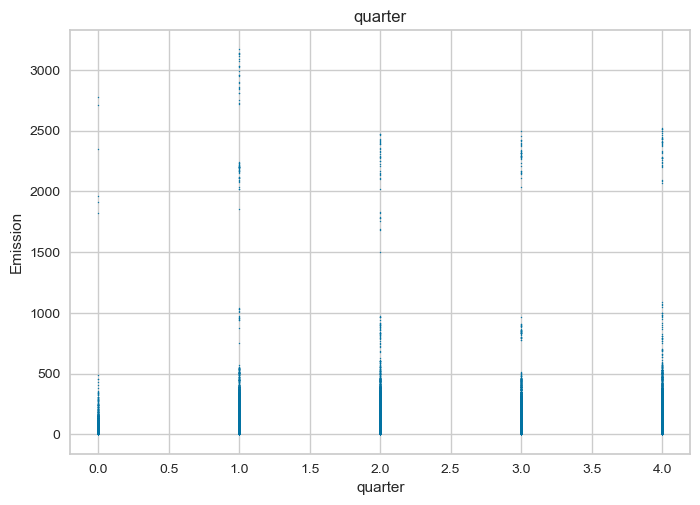

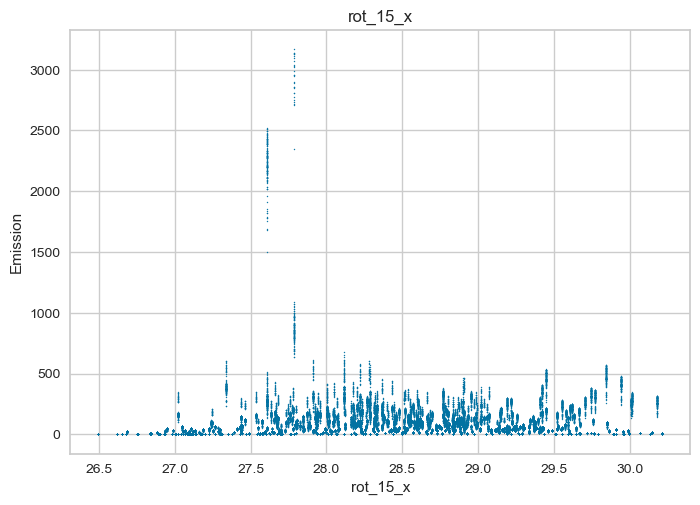

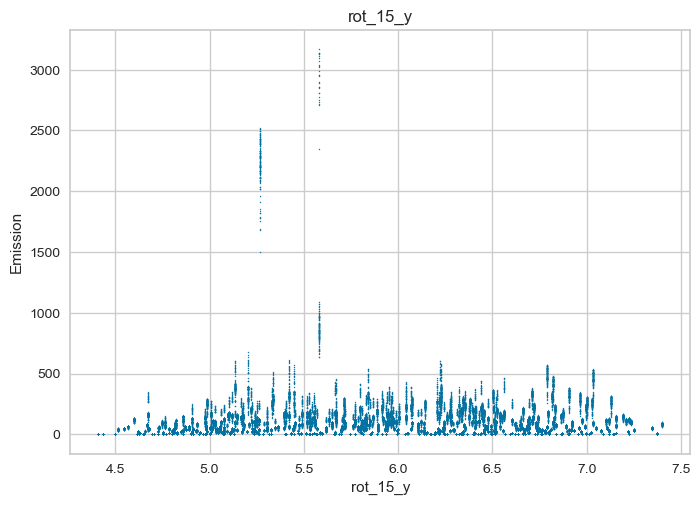

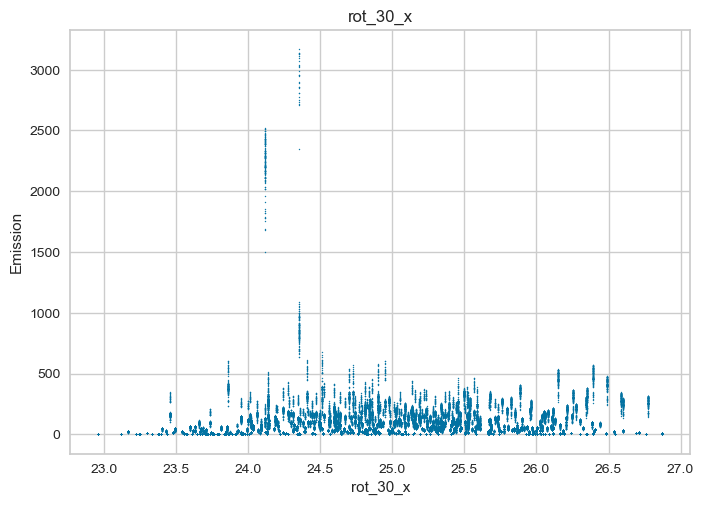

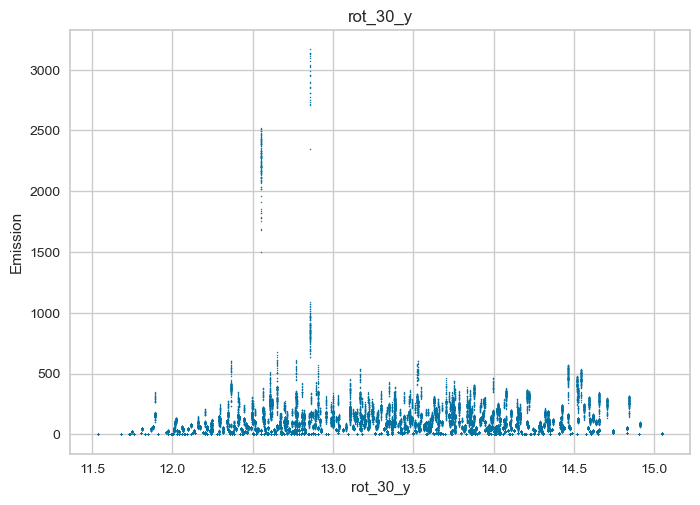

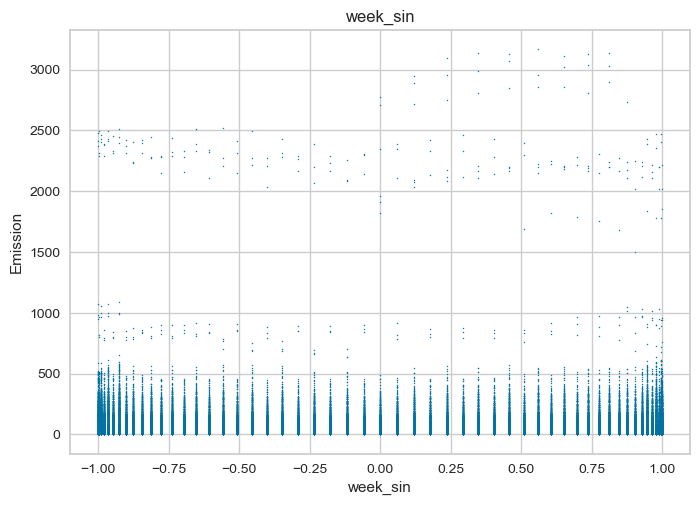

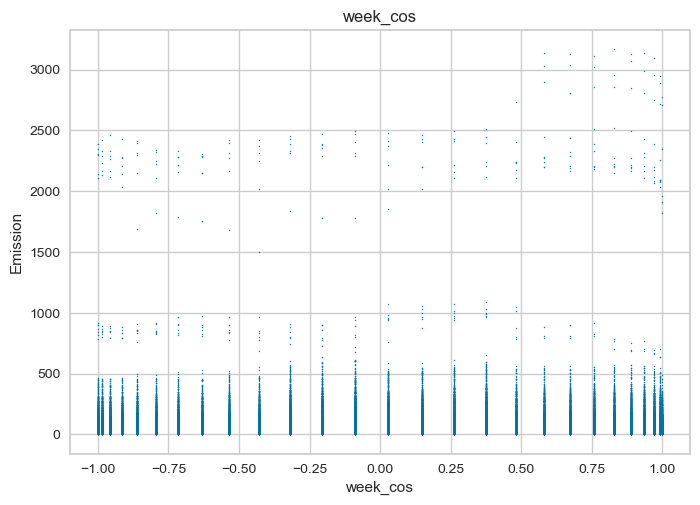

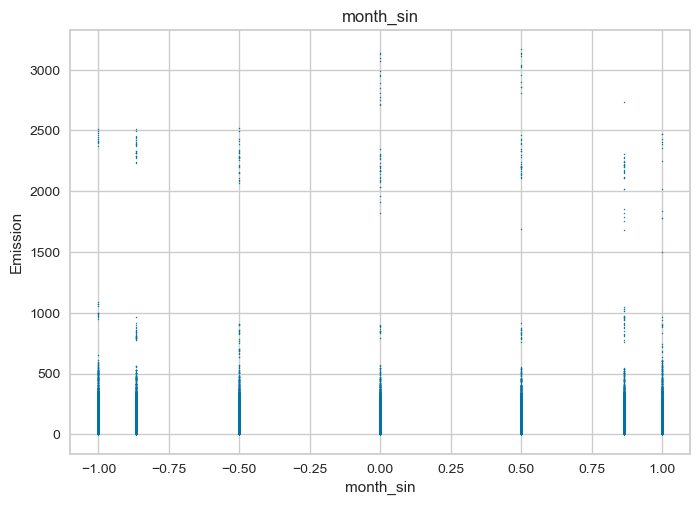

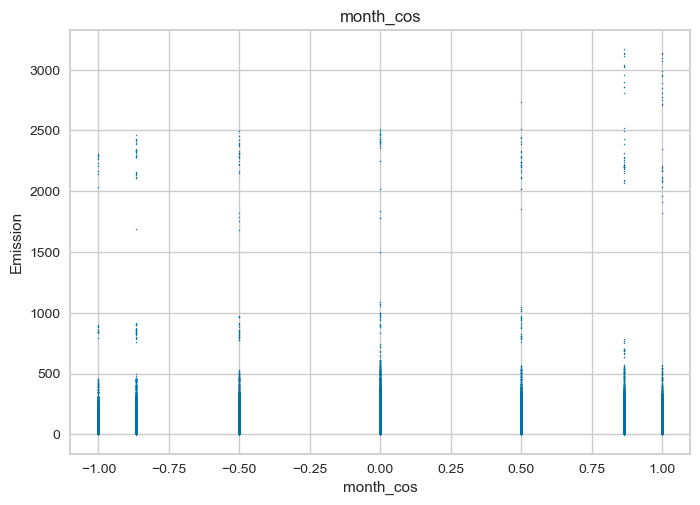

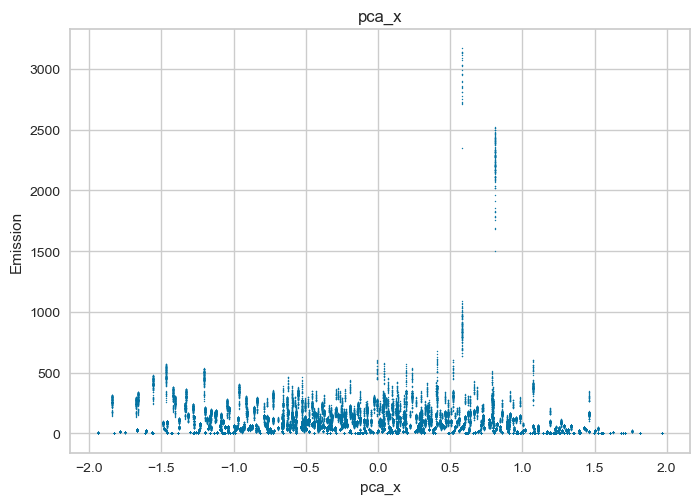

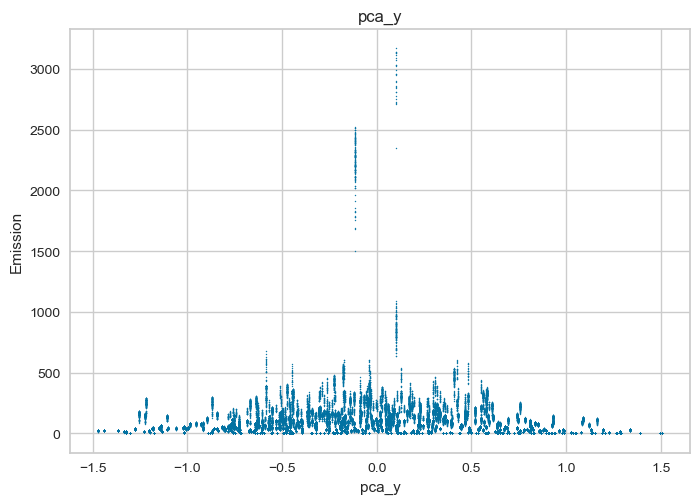

In [134]:
for label in X_train.columns:
    plt.scatter(X_train[label], y_train, s=0.5)
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel("Emission")
    plt.show()






In [135]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
X_train_splitted, X_val, y_train_splitted, y_val = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

In [114]:
model = RandomForestRegressor(n_jobs=-1, random_state=368)

In [115]:
model.fit(X_train_splitted, y_train_splitted)

RandomForestRegressor(n_jobs=-1, random_state=368)

In [116]:
pred_val = model.predict(X_val)
score_val = mean_absolute_error(pred_val, y_val)
print(model, "has a mean absolute error :", score_val)

RandomForestRegressor(n_jobs=-1, random_state=368) has a mean absolute error : 3.3142919345192863


In [117]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=368)

In [118]:
pred = model.predict(test)

In [119]:
submission = pd.read_csv('sample_submission.csv')
submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,81.94
1,ID_-0.510_29.290_2022_01,81.94
2,ID_-0.510_29.290_2022_02,81.94
3,ID_-0.510_29.290_2022_03,81.94
4,ID_-0.510_29.290_2022_04,81.94
...,...,...
24348,ID_-3.299_30.301_2022_44,81.94
24349,ID_-3.299_30.301_2022_45,81.94
24350,ID_-3.299_30.301_2022_46,81.94
24351,ID_-3.299_30.301_2022_47,81.94


In [120]:
submission['emission'] = pred
submission

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,3.532882
1,ID_-0.510_29.290_2022_01,4.044670
2,ID_-0.510_29.290_2022_02,4.104194
3,ID_-0.510_29.290_2022_03,4.137706
4,ID_-0.510_29.290_2022_04,4.188500
...,...,...
24348,ID_-3.299_30.301_2022_44,29.545110
24349,ID_-3.299_30.301_2022_45,29.647583
24350,ID_-3.299_30.301_2022_46,29.745684
24351,ID_-3.299_30.301_2022_47,29.998443


In [121]:
submission.to_csv('submission_v1.csv', index=False)